## Cross Slope heat transport on T grid

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr
import numpy as np

from dask.distributed import Client

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 250.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36335,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 250.00 GiB
Comm: tcp://127.0.0.1:34231,Total threads: 4
Dashboard: /proxy/39523/status,Memory: 35.71 GiB
Nanny: tcp://127.0.0.1:42499,


In [3]:
session = cc.database.create_session()

In [4]:
experiment = '01deg_jra55v13_ryf9091'

########################################################################################
#Setting the number of days in each month, so I can have the full date fo each month
#             J,  F,  M,  A,  M,  J,  J,  A,  S,  O,  N,  D]
monthdays = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
########################################################################################

start_time='2095-01'
end_time='2095-02'

#FOr importing the daily transports
start_time0='2095-01-01' 
end_time0='2095-01-' + str(monthdays[1-1])
time_period = str(int(start_time[:4]))+'-'+str(int(end_time[:4]))
#########################################################################################
lat_range = slice(-90,-59)

isobath_depth = 1000
time_slice = slice(start_time, end_time)

Below we select the contour we want. Save it so you only have to run it once. If you have already calculated the contour before skip this line and run the next one

In [5]:
%%time

yt_ocean = cc.querying.getvar(experiment, 'yt_ocean', session, n=1)
yt_ocean = yt_ocean.sel(yt_ocean = lat_range)

xt_ocean = cc.querying.getvar(experiment, 'xt_ocean', session, n=1)

yu_ocean = cc.querying.getvar(experiment, 'yu_ocean', session, n=1)
yu_ocean = yu_ocean.sel(yu_ocean = lat_range)

xu_ocean = cc.querying.getvar(experiment, 'xu_ocean', session, n=1)



if len(yt_ocean) != len(yu_ocean):
    print('help! y different size')

if yt_ocean.min('yt_ocean')> yu_ocean.min('yu_ocean'):
    print('help! wrong order')

if len(xt_ocean) != len(xu_ocean):
    print('help! x different size')

if xt_ocean.min('xt_ocean')> xu_ocean.min('xu_ocean'):
    print('help! x wrong order')


hu = cc.querying.getvar(experiment,'hu', session, n=1)

# select one year and latitude range
hu = hu.sel(yu_ocean = lat_range)

# weighted time-mean by month length
hu_mean = hu

contour_depth = 1000 #1000m isobath

h = hu_mean.load()

# Fill in land with zeros:
h = h.fillna(0)

CPU times: user 9.44 s, sys: 2.17 s, total: 11.6 s
Wall time: 48.4 s


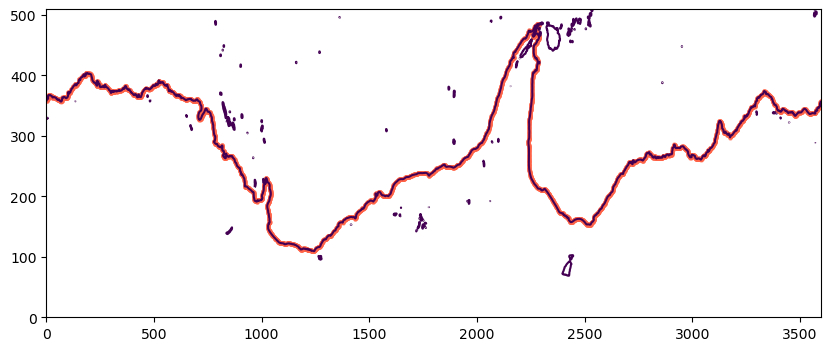

In [6]:
# We need the contour to be on the u grid to match u.v calculated by Wilma on the u grid
grid_sel = 'u'

if grid_sel == 'u':
    x_var = xu_ocean
    y_var = yu_ocean
elif grid_sel == 't':
    x_var = xt_ocean
    y_var = yt_ocean



fig = plt.figure(figsize = (10, 4))
count = 1
x_contour = []
y_contour = []

# Create the contour:
sc = plt.contour(h, levels=[contour_depth])
for collection in sc.collections:
    for path in collection.get_paths():
        count += 1
        if count ==  2:
            # Write down the lat/lon indices
            for ii in range(np.size(path.vertices[:,0])):
                x_contour.append(int(np.round(path.vertices[ii][0])))
                y_contour.append(int(np.round(path.vertices[ii][1])))

plt.scatter(x_contour, y_contour, s=5, alpha=0.5, color='tomato');


# Difference between two neighbouring indices
diff_x_contour = np.diff(x_contour)
diff_y_contour = np.diff(y_contour)

# Get a list with the indices of duplicates
diff_ind = []
for ii in range(len(diff_x_contour)):
    if (diff_x_contour[ii]==0) and (diff_y_contour[ii]==0):
        diff_ind.append(ii)


# Now remove the indices (start from the end so the indices don't shift)
for ii in range(len(diff_ind)):
    index = diff_ind[::-1][ii]
    del x_contour[index]
    del y_contour[index]
    
    
    
h_contour = np.zeros(len(x_contour))

for ii in range(len(h_contour)):
    h_contour[ii] = h[y_contour[ii], x_contour[ii]]

    
lat_along_contour = np.zeros((len(x_contour)))
lon_along_contour = np.zeros((len(x_contour)))

for ii in range(len(h_contour)):
    lon_along_contour[ii] = x_var[x_contour[ii]]
    lat_along_contour[ii] = y_var[y_contour[ii]]
    
    
#The new contour created here will have to be used in the new calculatons of U transport in Wilma's code. So lets create the new variables and save them into a netcdf
num_points = np.size(lon_along_contour)

import geopy.distance
distance_along_contour=np.zeros(num_points)
for n in range(num_points-1):
    coords_1 = (lat_along_contour[n], lon_along_contour[n])
    coords_2 = (lat_along_contour[n+1], lon_along_contour[n+1])
    distance_along_contour[n+1] = geopy.distance.geodesic(coords_1, coords_2).km
distance_along_contour=np.cumsum(distance_along_contour)

Dlon_along_contour=xr.DataArray(lon_along_contour)
Dlat_along_contour=xr.DataArray(lat_along_contour)
Dnum_points=xr.DataArray(num_points)
Ddistance_along_contour=xr.DataArray(distance_along_contour)

SaveContour = xr.Dataset(data_vars=dict(
    distance_along_contour=(["lon_along_contour"], distance_along_contour),
    lat_along_contour=(["lon_along_contour"], lat_along_contour),),
                        coords=dict(lon_along_contour=(["lon_along_contour"], lon_along_contour)))

SaveContour.to_netcdf('/g/data/x77/wf4500/ASC_project/model_data/Contours/coods_1000m_ugrid_isobath_Claires_method.nc')

Saving the contour

In [26]:
SaveContour = xr.open_dataset('/g/data/x77/wf4500/ASC_project/model_data/Contours/coods_1000m_ugrid_isobath_Claires_method.nc')
lon_along_contour=SaveContour.lon_along_contour
lat_along_contour=SaveContour.lat_along_contour
distance_along_contour=SaveContour.distance_along_contour
num_points=np.size(lon_along_contour)

Repeat the leftmost point at the end of the array.

(Required for masking contour above and below)

In [27]:
lat_along_contour = np.append(lat_along_contour, lat_along_contour[0])
lon_along_contour = np.append(lon_along_contour, lon_along_contour[0])
# Number of grid points on the contour
num_points = len(lat_along_contour)

Now we number the points along the contour

In [58]:
contour_mask_numbered = np.zeros_like(lon_along_contour)
y_contour2 = np.zeros_like(lon_along_contour)
x_contour2 = np.zeros_like(lon_along_contour)

for ii in range(num_points-1):
    lat1 = lat_along_contour[ii]
    lat2 = lat_along_contour[ii+1]
    lon1 = lon_along_contour[ii]
    lon2 = lon_along_contour[ii+1]
    y_contour2[ii]=np.int(np.argwhere(np.array(yu_ocean)==lat1))
    x_contour2[ii]=np.int(np.argwhere(np.array(xu_ocean)==lon1))
    contour_mask_numbered[ii] = ii
    
y_contour2[-1]=np.int(np.argwhere(np.array(yu_ocean)==lat_along_contour[-1]))
x_contour2[-1]=np.int(np.argwhere(np.array(xu_ocean)==lon_along_contour[-1]))

In [65]:
contour_mask =h*0.0 #original is h*0 instead of h/h. And below line doesnt exist

for ii in range(num_points-1):
    contour_mask[int(y_contour2[ii]), int(x_contour2[ii])] = contour_mask_numbered[ii]+1

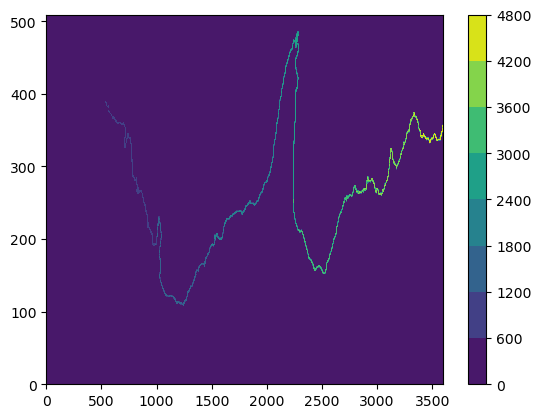

In [66]:
plt.contourf(contour_mask); plt.colorbar()

Create mask

Now we create a mask below contour so that the direction of the contour can be determined

Remark on computational inefficiency

Note that creating masks with nested for loops is very inefficient. We should probably use boolean masks (just compare the entire array with mask_value), and DataArray.shift() or DataArray.roll() from each of the directions to generate the masks without using loops.

See discussion in: https://github.com/COSIMA/cosima-recipes/issues/179

In [67]:
mask_value = -1000
contour_mask_numbered = contour_mask

# fill in points to south of contour:
contour_masked_above = np.copy(contour_mask_numbered)
contour_masked_above[-1,0] = mask_value

# from top left:
for ii in range(len(contour_mask.xu_ocean)-1):
    for jj in range(len(contour_mask.yu_ocean))[::-1][:-1]:
        if contour_masked_above[jj, ii] == mask_value:
            if contour_masked_above[jj-1, ii] == 0:
                contour_masked_above[jj-1, ii] = mask_value
            if contour_masked_above[jj, ii+1] == 0:
                contour_masked_above[jj, ii+1] = mask_value

#from top right:
for ii in range(len(contour_mask.xu_ocean))[::-1][:-1]:
    for jj in range(len(contour_mask.yu_ocean))[::-1][:-1]:
        if contour_masked_above[jj, ii] == mask_value:
            if contour_masked_above[jj-1, ii] == 0:
                contour_masked_above[jj-1, ii] = mask_value
            if contour_masked_above[jj, ii-1] == 0:
                contour_masked_above[jj, ii-1] = mask_value

# from bottom right:
for ii in range(len(contour_mask.xu_ocean))[::-1][:-1]:
    for jj in range(len(contour_mask.yu_ocean)-1):
        if contour_masked_above[jj, ii] == mask_value:
            if contour_masked_above[jj+1, ii] == 0:
                contour_masked_above[jj+1, ii] = mask_value
            if contour_masked_above[jj, ii-1] == 0:
                contour_masked_above[jj, ii-1] = mask_value

#from bottom left:
for ii in range(len(contour_mask.xu_ocean)-1):
    for jj in range(len(contour_mask.yu_ocean)-1):
        if contour_masked_above[jj, ii] == mask_value:
            if contour_masked_above[jj+1, ii] == 0:
                contour_masked_above[jj+1, ii] = mask_value
            if contour_masked_above[jj, ii+1] == 0:
                contour_masked_above[jj, ii+1] = mask_value

South of the contour, values have been filled in to be -100, and it is thus a different colour in the plot.

Direction of cross-contour transport

Now we can use the mask south of the contour to determine whether the transport across the contour should be north, east, south or west (the grid is made of discrete square(ish) shaped cells). This is done by looping through the contour points and determining in which directions there are zeros (above contour) and -100 (below contour). This means the orientation of the contour can be determined. This is saved as mask_x_transport, which has -1 and +1 in a 2D (x and y) array where the contour has eastward transport, and mask_y_transport which as -1 and +1 for coordinates with northward transport. All other positions in the array are 0. This means that multiplying the northward transport ty_trans by the mask_y_transport gives all the northward transport across the contour, and zeros everywhere else (e.g. where contour goes upwards and cross-contour transport is thus eastward).

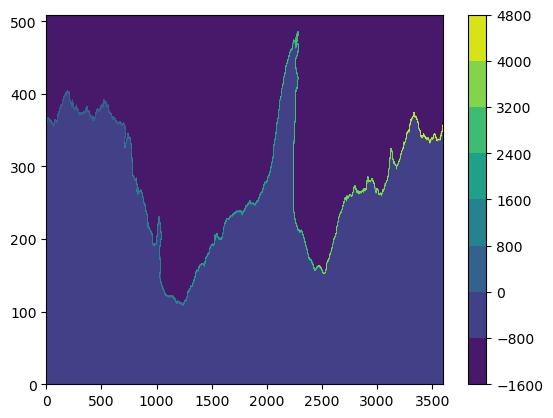

In [68]:
plt.contourf(contour_masked_above); plt.colorbar()

In [69]:
mask_x_transport = np.zeros_like(contour_mask_numbered)
mask_y_transport = np.zeros_like(contour_mask_numbered)

mask_y_transport_numbered = np.zeros_like(contour_mask_numbered)
mask_x_transport_numbered = np.zeros_like(contour_mask_numbered)

# make halos:
shape = contour_masked_above.shape
contour_masked_above_halo = np.zeros((shape[0], shape[1]+2))
contour_masked_above_halo[:, 0] = contour_masked_above[:, -1]
contour_masked_above_halo[:, 1:-1] = contour_masked_above
contour_masked_above_halo[:, -1] = contour_masked_above[:, 0]

new_number_count = 1
for mask_loc in range(1, int(np.max(contour_mask_numbered))+1):
    #if mask_loc%100 == 0:
    #    print('mask for x/y transport at point '+str(mask_loc))
    index_i = np.where(contour_mask_numbered==mask_loc)[1]
    index_j = np.where(contour_mask_numbered==mask_loc)[0]
    # if point above is towards Antarctica and point below is away from Antarctica:
    # take transport grid point to north of t grid:
    if (contour_masked_above[index_j+1, index_i]==0) and (contour_masked_above[index_j-1, index_i]!=0):
        mask_y_transport[index_j, index_i] = -1
        # important to do 
        mask_y_transport_numbered[index_j, index_i] = new_number_count
        new_number_count += 1
    # if point below is towards Antarctica and point above is away from Antarctica:
    # take transport grid point to south of t grid:
    elif (contour_masked_above[index_j-1, index_i]==0) and (contour_masked_above[index_j+1, index_i]!=0):
        mask_y_transport[index_j-1, index_i] = 1
        mask_y_transport_numbered[index_j-1, index_i] = new_number_count
        new_number_count += 1
    # if point to right is towards Antarctica and point to left is away from Antarctica:
    # zonal indices increased by 1 due to halos
    # take transport grid point on right of t grid:
    if (contour_masked_above_halo[index_j, index_i+2]==0) and (contour_masked_above_halo[index_j, index_i]!=0):
        mask_x_transport[index_j, index_i] = -1
        mask_x_transport_numbered[index_j, index_i] = new_number_count
        new_number_count += 1
    # if point to left is towards Antarctica and point to right is away from Antarctica:
    # take transport grid point on left of t grid:
    elif (contour_masked_above_halo[index_j, index_i]==0) and (contour_masked_above_halo[index_j, index_i+2]!=0):
        mask_x_transport[index_j, index_i-1] = 1
        mask_x_transport_numbered[index_j, index_i-1] = new_number_count
        new_number_count += 1

As can be seen, in mask_x_transport there is yellow (+1) where eastward transport crosses the contour, and (-1) where westward transport crosses the contour (in the net northward direction). There are zeros everywhere else.

We now have the coordinates of the contours, and whether the x or y transport is needed to calculate cross-contour transport.

We now proceed to calculate transports across the contour

In [70]:
# Convert contour masks to data arrays, so we can multiply them later.
# We need to ensure the lat lon coordinates correspond to the actual data location:
#       The y masks are used for ty_trans, so like vhrho this should have dimensions (yu_ocean, xt_ocean).
#       The x masks are used for tx_trans, so like uhrho this should have dimensions (yt_ocean, xu_ocean).
#       However the actual name will always be simply y_ocean/x_ocean irrespective of the variable
#       to make concatenation of transports in both direction and sorting possible.

mask_x_transport = xr.DataArray(mask_x_transport, coords = [yu_ocean, xu_ocean], dims = ['y_ocean','x_ocean'])
mask_y_transport = xr.DataArray(mask_y_transport, coords = [yu_ocean, xu_ocean], dims = ['y_ocean','x_ocean'])
mask_x_transport_numbered = xr.DataArray(mask_x_transport_numbered, coords = [yu_ocean, xu_ocean], dims = ['y_ocean','x_ocean'])
mask_y_transport_numbered = xr.DataArray(mask_y_transport_numbered, coords = [yu_ocean, xu_ocean], dims = ['y_ocean','x_ocean'])

Stack contour data into 1D

In [71]:
# Create the contour order data-array. Note that in this procedure the x-grid counts have x-grid
#   dimensions and the y-grid counts have y-grid dimensions, but these are implicit, the dimension 
#   *names* are kept general across the counts, the generic y_ocean, x_ocean, so that concatening works
#   but we dont double up with numerous counts for one lat/lon point.

# stack contour data into 1d:
mask_x_numbered_1d = mask_x_transport_numbered.stack(contour_index = ['y_ocean', 'x_ocean'])
mask_x_numbered_1d = mask_x_numbered_1d.where(mask_x_numbered_1d > 0, drop = True)

mask_y_numbered_1d = mask_y_transport_numbered.stack(contour_index = ['y_ocean', 'x_ocean'])
mask_y_numbered_1d = mask_y_numbered_1d.where(mask_y_numbered_1d > 0, drop = True)

contour_ordering = xr.concat((mask_x_numbered_1d, mask_y_numbered_1d), dim = 'contour_index')
contour_ordering = contour_ordering.sortby(contour_ordering)
contour_index_array = np.arange(1, len(contour_ordering)+1)

# Load transports tx_trans and ty_trans

Notice I used time = start_time in .sel here just for trying a monthly data. for daily data ill probably need to use a different appraoch ( possibly loop)

In [72]:
ty_trans = cc.querying.getvar(experiment, 'temp_yflux_adv', session, start_time = start_time, end_time = end_time)
ty_trans = ty_trans.sel(yu_ocean = lat_range).isel(time=0).sum('st_ocean')

tx_trans = cc.querying.getvar(experiment, 'temp_xflux_adv', session, start_time = start_time, end_time = end_time)
tx_trans = tx_trans.sel(yt_ocean = lat_range).isel(time=0).sum('st_ocean')

# ty_trans = ty_trans.rename({'yu_ocean': 'y_ocean', 'xt_ocean': 'x_ocean'}).load()
# tx_trans = tx_trans.rename({'yt_ocean': 'y_ocean', 'xu_ocean': 'x_ocean'}).sum('st_ocean').load()

Regridding the heat transports to be on the u grid

In [73]:
import xgcm
path_to_folder = '/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/'
grid = xr.open_mfdataset(path_to_folder+'ocean_grid.nc', combine='by_coords').isel(yt_ocean=slice(0,510),yu_ocean=slice(0,510))

ds = xr.merge([hu, grid])
ds.coords['xt_ocean'].attrs.update(axis='X')
ds.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5)
ds.coords['yt_ocean'].attrs.update(axis='Y')
ds.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)

grid = xgcm.Grid(ds, periodic=['X'])


#The components on the u grid are the ones below. Notice they were renamed for future steps
ty_trans = grid.interp(ty_trans, 'X').rename({'yu_ocean': 'y_ocean', 'xu_ocean': 'x_ocean'}).load()
tx_trans = grid.interp(tx_trans, 'Y').rename({'yu_ocean': 'y_ocean', 'xu_ocean': 'x_ocean'}).load()

Extract transport values along contour

In [93]:
#plt.contourf(ty_trans,vmin=-1e13,vmax=1e13); plt.colorbar()
#ty_trans.plot()

In [74]:
ty_transm=ty_trans*mask_y_transport
tx_transm=tx_trans*mask_x_transport

Extracting values along contour

In [75]:
from joblib import Parallel, delayed
def HT_paralel(lat_along_contour,lon_along_contour,tx_transm,ty_transm, n):  
    
    try:
        Ftemp_cross_contour_xg=tx_transm.sel(y_ocean=lat_along_contour[n],x_ocean=lon_along_contour[n])
    except:
        print('Value not on xgrid')
    try:
        Ftemp_cross_contour_yg=ty_transm.sel(y_ocean=lat_along_contour[n],x_ocean=lon_along_contour[n])
    except:
        print('Value not on ygrid either for n='+str(n))   
    Ftemp_cross_contour_xyg=np.array(Ftemp_cross_contour_xg) + np.array(Ftemp_cross_contour_yg)
    vary_full=Ftemp_cross_contour_xyg
    
    return vary_full
        
    
    

In [76]:
%%time
vol_trans_across_contour = Parallel(n_jobs=-1)(delayed(HT_paralel)(lat_along_contour,lon_along_contour,tx_transm,ty_transm,n) for n in range(num_points))




CPU times: user 3.3 s, sys: 1.11 s, total: 4.41 s
Wall time: 7.1 s


In [77]:
#vol_trans_across_contour[:-1]
#The fact taht we have so many absolute zeros make me thing that the mask values are probably in the wrong locations.

In [81]:
#vol_trans_across_contour

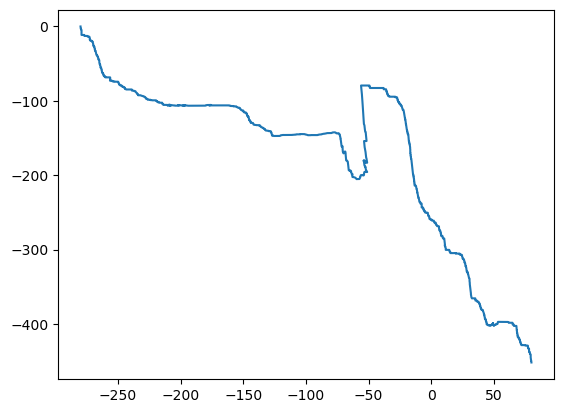

In [79]:
plt.plot(lon_along_contour[:-1],np.cumsum(vol_trans_across_contour[:-1])/1e12)